In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("PCAWithPySpark").getOrCreate()

merged_df = spark.read.csv("Updated_Merged_Dataset.csv", header=True, inferSchema=True)

selected_features = ['HDI', 'TC', 'TD', 'STI', 'POP']
vector_assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
merged_df_vectorized = vector_assembler.transform(merged_df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(merged_df_vectorized)
merged_df_standardized = scaler_model.transform(merged_df_vectorized)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/07 05:59:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/07 05:59:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/07 05:59:19 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Explained Variance: [0.4791399877596936,0.2591694531740578,0.14723546828570874,0.10249405202374948,0.011961038756790386]


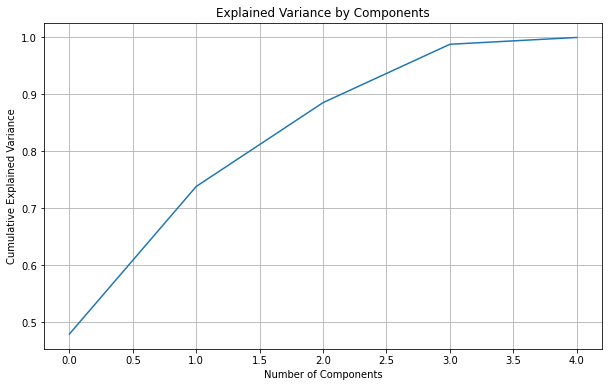

           HDI        TC        TD       STI       POP
PC-1 -0.023841 -0.605193 -0.610149 -0.442301 -0.255461
PC-2  0.761847  0.123988  0.107346  0.003135 -0.626645
PC-3 -0.385704 -0.098449 -0.199114  0.729850 -0.518858
PC-4 -0.516660  0.361320  0.255386 -0.521102 -0.515500
PC-5  0.057587  0.691465 -0.715071 -0.011466  0.084274


In [5]:
pca = PCA(k=len(selected_features), inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(merged_df_standardized)
merged_df_pca = pca_model.transform(merged_df_standardized)

explained_variance = pca_model.explainedVariance
print(f"Explained Variance: {explained_variance}")

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

components = pca_model.pc.toArray().T.tolist()
components_df = pd.DataFrame(components, columns=selected_features, index=[f'PC-{i+1}' for i in range(len(explained_variance))])
print(components_df)

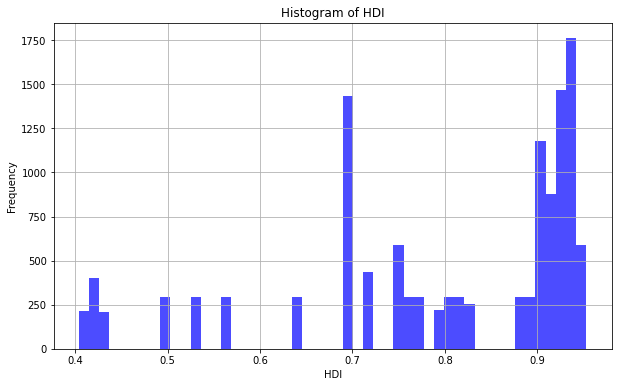

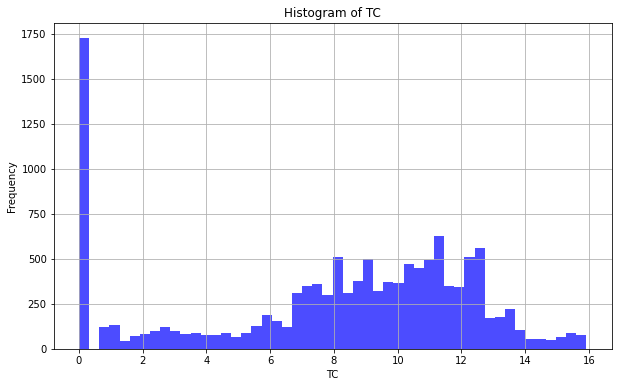

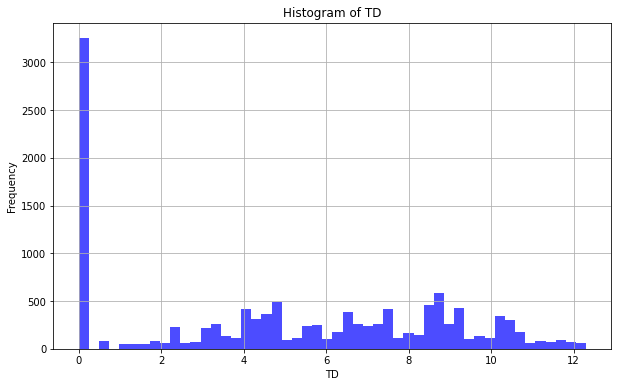

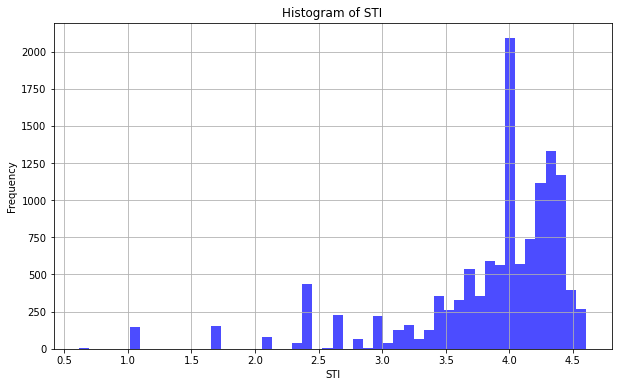

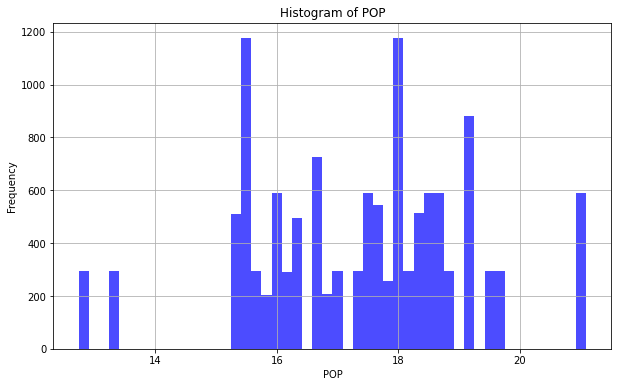

In [6]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("HistogramPlotting").getOrCreate()
merged_df = spark.read.csv('Updated_Merged_Dataset.csv', header=True, inferSchema=True)

selected_features = ['HDI', 'TC', 'TD', 'STI', 'POP']

for feature in selected_features:
    hist_data = merged_df.select(feature).rdd.flatMap(lambda x: x).histogram(50)
    
    bin_edges = hist_data[0]
    bin_counts = hist_data[1]
    
    plt.figure(figsize=(10,6))
    plt.hist(bin_edges[:-1], bin_edges, weights=bin_counts, color='blue', alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()